In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
import os
torch.cuda.is_available()
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
print(device)

cuda:1


In [2]:
from phonopy import Phonopy

In [3]:

class Net(nn.Module):
    def __init__(self, input_size):
        super(Net, self).__init__()
        self.norm = nn.BatchNorm1d(input_size)  # 归一化层
        # self.layers = nn.Sequential(
        #     nn.Linear(input_size, 1500),
        #     nn.LeakyReLU(),
        #     nn.Dropout(0.5),  # Dropout层
        #     nn.Linear(1500, 900),
        #     nn.LeakyReLU(),
        #     nn.Dropout(0.5),  # Dropout层
        #     nn.Linear(900, 450),
        #     nn.LeakyReLU(),
        #     nn.Dropout(0.5),  # Dropout层
        #     nn.Linear(450, 150),
        #     nn.Softmax(),
        #     nn.Linear(150, 1)
        # )
        self.layers = nn.Sequential(
            nn.Linear(input_size, 2048),
            nn.LeakyReLU(),
            nn.Dropout(0.3),  # Dropout层
            nn.Linear(2048, 1024),
            nn.LeakyReLU(),
            nn.Dropout(0.3),  # Dropout层
            nn.Linear(1024, 512),
            nn.LeakyReLU(),
            nn.Dropout(0.2),  # Dropout层
            nn.Linear(512, 256),
            nn.Linear(256, 1)
        )

    def forward(self, x):
        x = self.norm(x)
        return self.layers(x)

class MyDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]



In [13]:
%time
# dos and qdos
def NeDos(dos, energy):
    loc = int(energy.item())  # Convert tensor to python scalar
    ls_dos = dos.clone()
    ls_dos[loc:] = -ls_dos[loc:]
    return ls_dos

def Energy_loc(tot_num, energy): 
    loc = torch.round(tot_num / 150 * energy).long()  # Converted to long for indexing
    return loc

def Prepare(path,aroundpath,NumOneHot):
    device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
    print(path)
    dpath = path + 'DataSet/'
    energy = torch.from_numpy(np.loadtxt(dpath + 'EnergyFull')).to(device)
    nband = energy.shape[1]
    energy = torch.flatten(energy.t()).view(len(energy)*nband,1)
    QP = torch.from_numpy(np.loadtxt(dpath + 'QPFull')).to(device)
    QP = QP.repeat(nband,1)
    Tau = torch.from_numpy(np.loadtxt(dpath + 'TauFull')).to(device)
    Tau = torch.flatten(Tau.t()).view(len(Tau)*nband,1)
    vx = torch.from_numpy(np.loadtxt(dpath + 'VXFull')).to(device)
    vx = vx[:,1:]
    vx = torch.flatten(vx.t()).view(len(vx)*nband,1)
    vx = vx.pow(2)
    print(QP.shape, energy.shape, vx.shape, Tau.shape)
    all_data = torch.cat((QP, energy, vx, Tau), 1)
    nkpt = all_data.size(0)
    print('all_data.shape',all_data.shape)
    print('Data:Qpoints, energy, square velocity, Tau')
    print(nkpt)
    na, nb,nc,ne = 30,30,30, NumOneHot 
    One_hot = torch.zeros((na,nb,nc,ne), device=device)
    print(One_hot.shape)
    oh_data = all_data[:,0:4].clone()
    oh_data[:,0:3] = oh_data[:,0:3] / 0.033333
    oh_data[:,3] = Energy_loc(NumOneHot,oh_data[:,3])
    oh_data = oh_data.type(torch.int)
    print('max energy',torch.max(oh_data[:,3]))
    for qp in range(nkpt):
        One_hot[oh_data[qp][0],oh_data[qp][1],oh_data[qp][2],oh_data[qp][3]] += 1

    # Weight:
    Weight = torch.ones(nkpt)
    # print(all_data[3,:].detach())

    # print(torch.where(Weight == 0))
    # print(torch.where[all_data[:,0:3] == torch.tensor([0,0,0],device=device)])
    loc = torch.where((all_data[:,0] == 0) & (all_data[:,1] == 0) & (all_data[:,2] == 0))
    print('loc0',loc[0][3])
    lowOptic = all_data[loc[0][3]][3]
    print('low Optic',lowOptic)
    indice = torch.where(all_data[:,3] <= lowOptic)
    print('number of low energy:',indice[0].__len__())
    Weight[indice[0]] = 5
    # print(Weight.__len__())
    # print(Weight)
    print('zero energy',torch.where(all_data[:,3] == 0))
    indice = torch.where(all_data[:,3] == 0)
    Weight[indice[0]] = 0

    dos = torch.zeros((nkpt,NumOneHot ), device=device)
    Totdos = torch.sum(One_hot,dim=(0,1,2))
    for qp in range(nkpt):
        dos[qp] = NeDos(Totdos,oh_data[qp][3])
    dos = dos / One_hot[20,:,:].numel() * NumOneHot 

    qdos = torch.zeros((nkpt,NumOneHot ), device=device)
    print(One_hot[20,:,:].numel() )
    for qp in range(nkpt):
        xindex = oh_data[qp][0]
        qpdos = torch.sum(One_hot[xindex,:,:],dim=(0,1))
        qdos[qp] = NeDos(qpdos,oh_data[qp][3]) / One_hot[xindex,:,:].numel() * NumOneHot 

    if os.path.exists(path+aroundpath):
        print('around Dos exists')
        around_dos = torch.load(path + aroundpath,map_location=device)
        around_dos = around_dos.view(nkpt,15 * NumOneHot )
    else:
        print('Can not find around DOS')
    labels = all_data[:,all_data.shape[1]-1:]

    print(path, 'oh_data, One_hot, dos, qdos, around_dos,labels')
    return all_data,oh_data, One_hot, dos, qdos, around_dos,labels,Weight

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 12.6 µs


In [14]:
NumOneHot = 300
all_data1,oh_data1, One_hot1, dos1, qdos1, around_dos1, labels1,Weight1 = Prepare('MgO/', 'around_dos_tensor.pth',    NumOneHot)
all_data2,oh_data2, One_hot2, dos2, qdos2, around_dos2, labels2,Weight2 = Prepare('InSb/', 'around_dos_tensor.pth',    NumOneHot)

MgO/
torch.Size([162000, 3]) torch.Size([162000, 1]) torch.Size([162000, 1]) torch.Size([162000, 1])
all_data.shape torch.Size([162000, 6])
Data:Qpoints, energy, square velocity, Tau
162000
torch.Size([30, 30, 30, 300])
max energy tensor(252, device='cuda:1', dtype=torch.int32)
loc0 tensor(81000, device='cuda:1')
low Optic tensor(69.6717, device='cuda:1', dtype=torch.float64)
number of low energy: 72598
zero energy (tensor([    0, 27000, 54000], device='cuda:1'),)
270000
around Dos exists
MgO/ oh_data, One_hot, dos, qdos, around_dos,labels
InSb/
torch.Size([162000, 3]) torch.Size([162000, 1]) torch.Size([162000, 1]) torch.Size([162000, 1])
all_data.shape torch.Size([162000, 6])
Data:Qpoints, energy, square velocity, Tau
162000
torch.Size([30, 30, 30, 300])
max energy tensor(70, device='cuda:1', dtype=torch.int32)
loc0 tensor(81000, device='cuda:1')
low Optic tensor(31.7653, device='cuda:1', dtype=torch.float64)
number of low energy: 101476
zero energy (tensor([    0, 27000, 54000], dev

In [9]:
features1 = torch.cat((dos1, qdos1, around_dos1), dim=1)
features2 = torch.cat((dos2, qdos2, around_dos2), dim=1)

In [11]:
# 假设你有一批新的特征数据，存储在变量 new_features 中
# new_features = np.load('aroun')  # 这是一个包含10个样本，每个样本有2550个特征的张量

# 加载模型
model = Net(NumOneHot * 17)
model.to(device)
model.load_state_dict(torch.load('model_tensor_weight_Huber.pth'))
model.eval()

# 使用模型进行预测
with torch.no_grad():
    prediction1 = model(features1)
    prediction2 = model(features2)

# print(prediction1)
# print(prediction2)

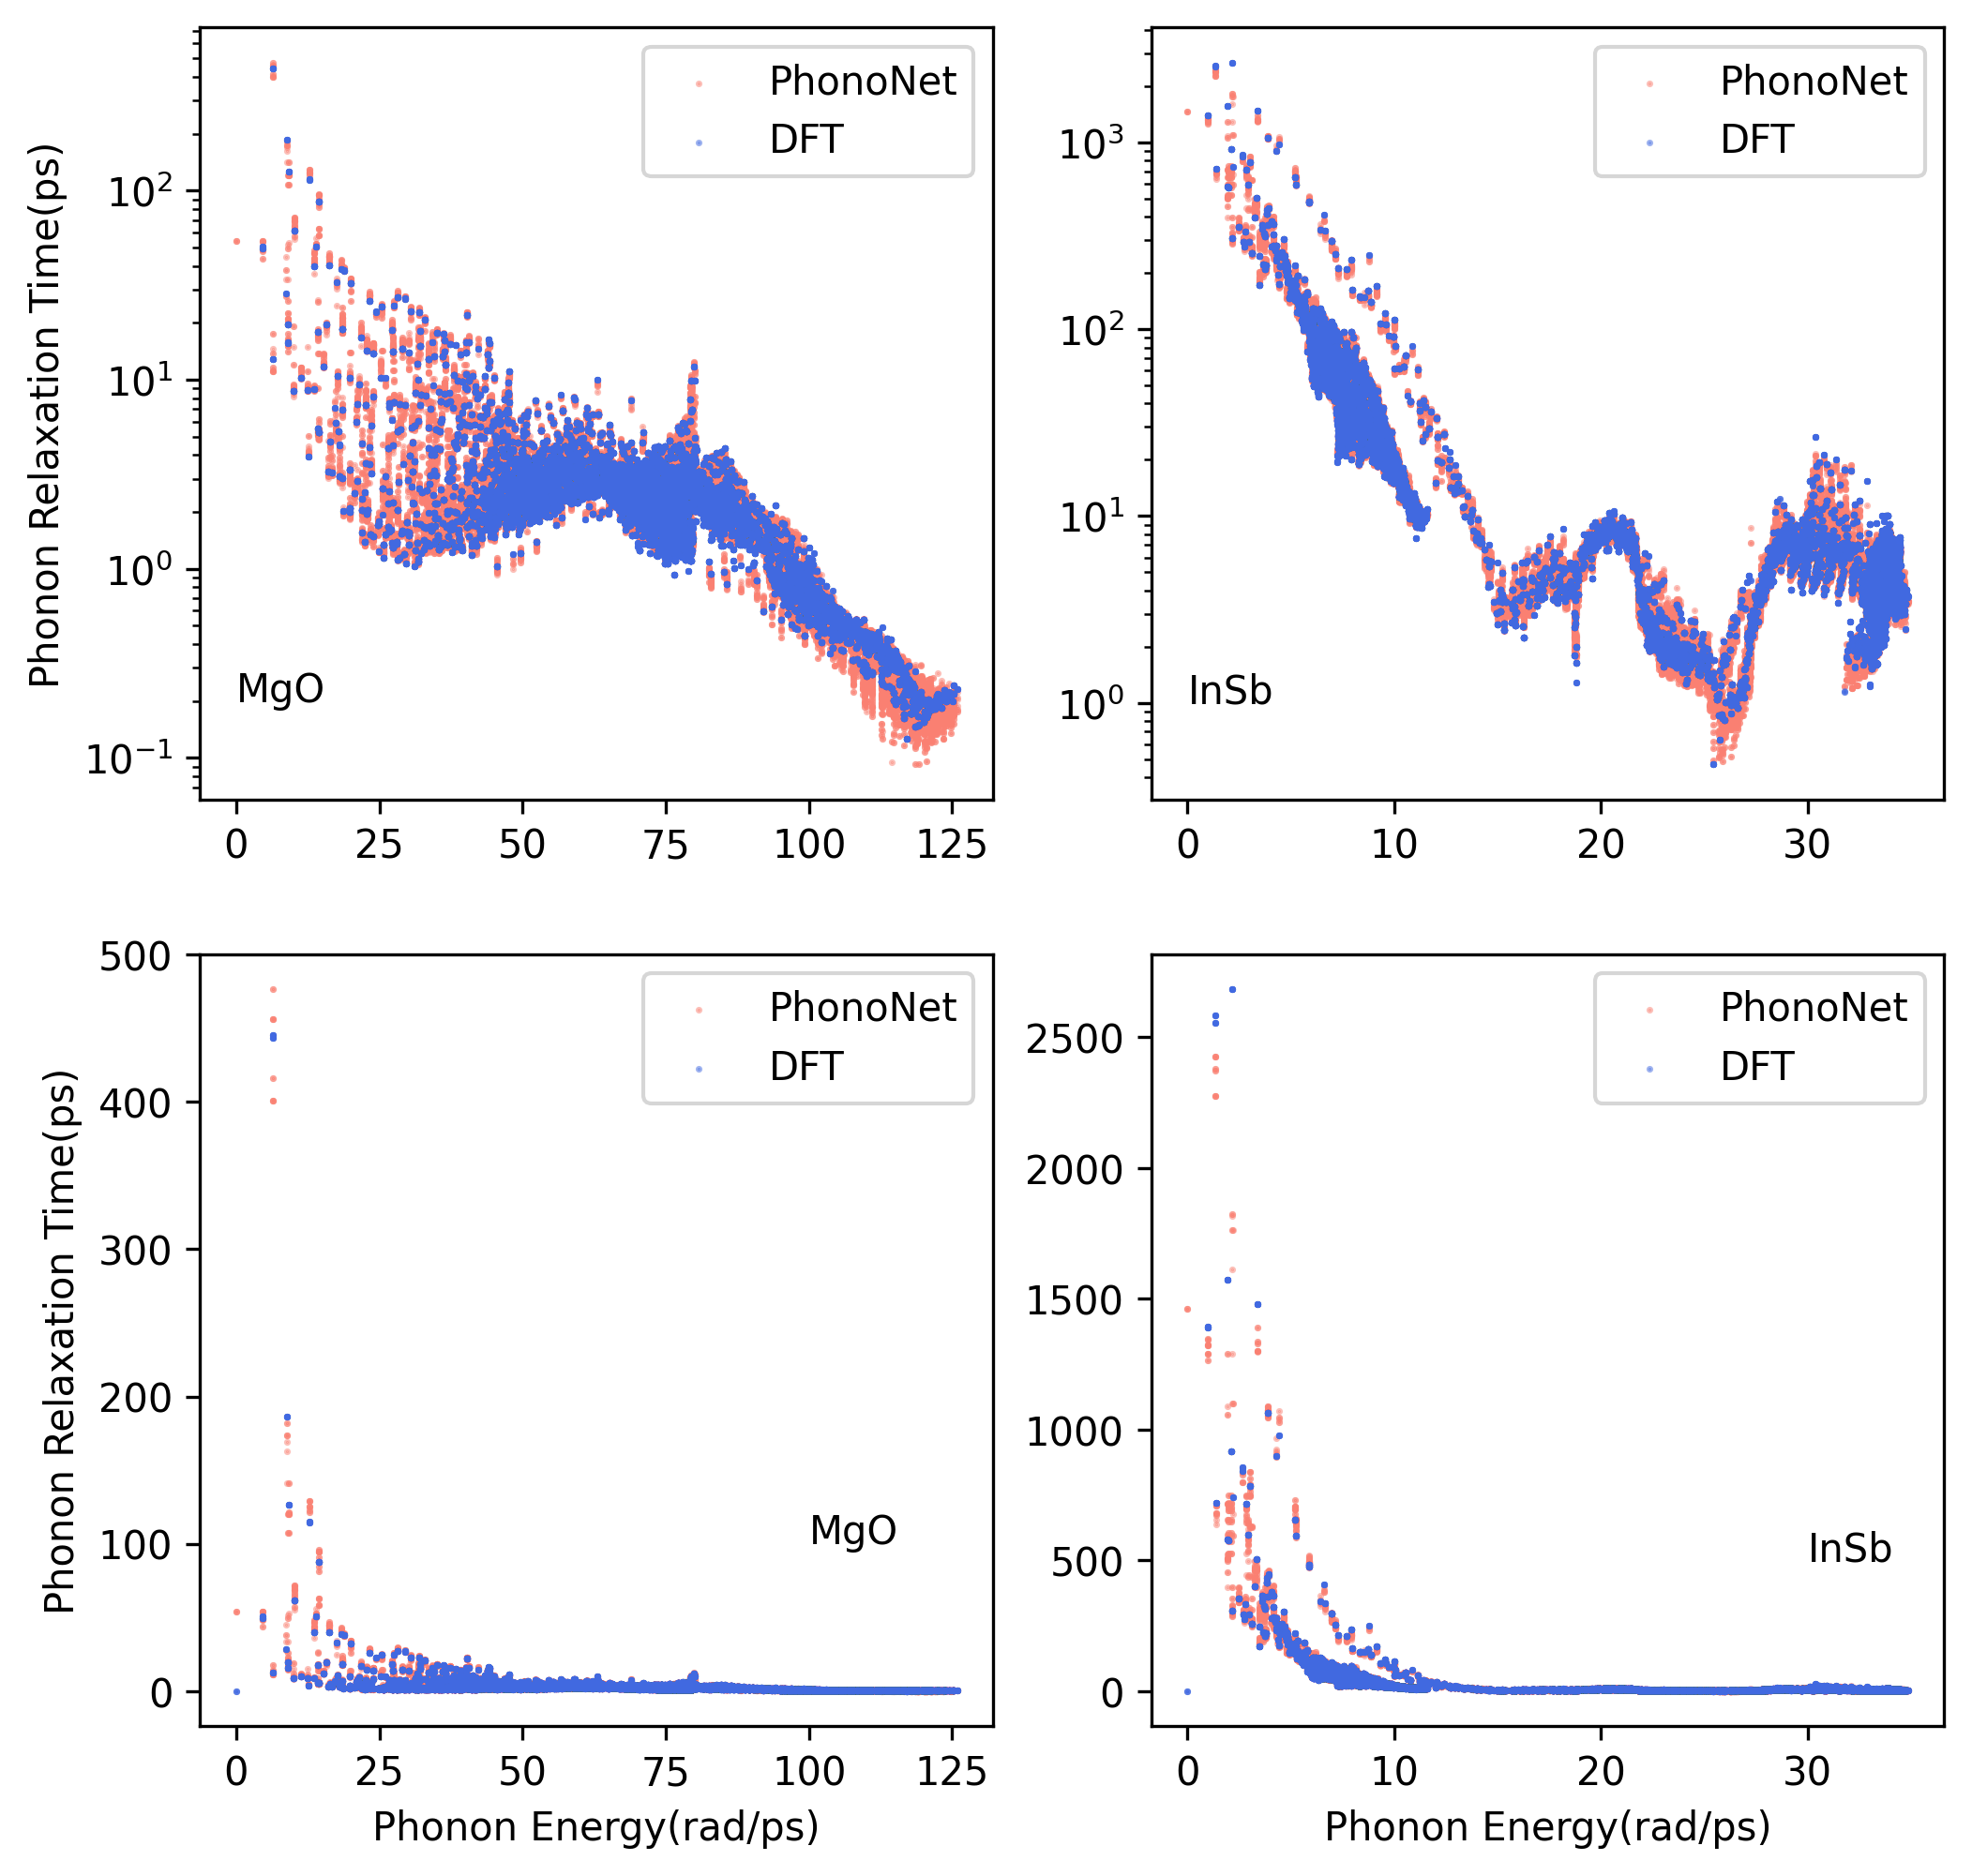

In [16]:
prediction1 = prediction1.cpu()
prediction2 = prediction2.cpu()
all_data1 = all_data1.cpu()
all_data2 = all_data2.cpu()
labels1 = labels1.cpu()
labels2 = labels2.cpu()
ls_prediction1 = prediction1 * 40.3 / 200
ls_prediction2 = prediction2 * 236.6 / 200
# MgO InSb
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(8,8),dpi=300)
ax1.scatter(all_data1[:,3],ls_prediction1,c='salmon',alpha=0.5,s=0.5,label='PhonoNet')
ax1.scatter(all_data1[:,3],labels1,c='royalblue',alpha=0.5,s=0.5,label='DFT')
ax1.set_yscale('log')
ax1.legend()
ax1.set_ylabel('Phonon Relaxation Time(ps)')
ax1.text(0,0.2,'MgO')
ax2.scatter(all_data2[:,3],ls_prediction2,c='salmon',alpha=0.5,s=0.5,label='PhonoNet')
ax2.scatter(all_data2[:,3],labels2,c='royalblue',alpha=0.5,s=0.5,label='DFT')
ax2.set_yscale('log')
ax2.legend()
ax2.text(0,1,'InSb')
ax3.scatter(all_data1[:,3],ls_prediction1,c='salmon',alpha=0.5,s=0.5,label='PhonoNet')
ax3.scatter(all_data1[:,3],labels1,c='royalblue',alpha=0.5,s=0.5,label='DFT')
# ax3.set_yscale('log')
ax3.legend()
ax3.set_ylabel('Phonon Relaxation Time(ps)')
ax3.set_xlabel('Phonon Energy(rad/ps)')
ax3.text(100,100,'MgO')
ax4.scatter(all_data2[:,3],ls_prediction2,c='salmon',alpha=0.5,s=0.5,label='PhonoNet')
ax4.scatter(all_data2[:,3],labels2,c='royalblue',alpha=0.5,s=0.5,label='DFT')
# ax5.set_yscale('log')
ax4.legend()
ax4.text(30,500,'InSb')
ax4.set_xlabel('Phonon Energy(rad/ps)')
plt.savefig('tau.png',dpi=600)
np.savetxt('prediction1.txt',ls_prediction1)
np.savetxt('prediction2.txt',ls_prediction2)